<a href="https://www.kaggle.com/code/xrajat/road-traffic-accident?scriptVersionId=104070150" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go 
import plotly.tools as tls
import plotly.figure_factory as ff

from collections import Counter
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle, class_weight
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            recall_score, precision_score, f1_score,
                            confusion_matrix)

from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

# !pip install --quiet shap==0.39.0
import shap

%matplotlib inline

sns.set_style('darkgrid')
pd. set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.



In [ ]:
print("test
      ")

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/visalakshi2001/rta-severity-prediction/main/RTA%20Dataset.csv")

# Exploratory Data Analysis

In [3]:
df.shape

(12316, 32)

In [4]:
df.columns

Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved',
       'Number_of_casualties', 'Vehicle_movement', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')

In [5]:
# renaming columns
col_map={'Time': 'time','Day_of_week': 'day_of_week','Age_band_of_driver': 'driver_age','Sex_of_driver': 'driver_sex',
         'Educational_level': 'educational_level','Vehicle_driver_relation': 'vehicle_driver_relation','Driving_experience': 'driving_experience',
         'Type_of_vehicle': 'vehicle_type','Owner_of_vehicle': 'vehicle_owner','Service_year_of_vehicle': 'service_year','Defect_of_vehicle': 'vehicle_defect',
         'Area_accident_occured': 'accident_area','Lanes_or_Medians': 'lanes','Road_allignment': 'road_allignment','Types_of_Junction': 'junction_type',
         'Road_surface_type': 'surface_type','Road_surface_conditions': 'road_surface_conditions','Light_conditions': 'light_condition',
         'Weather_conditions': 'weather_condition','Type_of_collision': 'collision_type','Number_of_vehicles_involved': 'vehicles_involved',
         'Number_of_casualties': 'casualties','Vehicle_movement': 'vehicle_movement','Casualty_class': 'casualty_class',
         'Sex_of_casualty': 'casualty_sex' , 'Age_band_of_casualty': 'casualty_age', 'Casualty_severity': 'casualty_severity',
         'Work_of_casuality': 'casualty_work', 'Fitness_of_casuality': 'casualty_fitness','Pedestrian_movement': 'pedestrian_movement',
         'Cause_of_accident': 'accident_cause','Accident_severity': 'accident_severity'}
df.rename(columns=col_map, inplace=True)
del col_map
gc.collect()

4

In [6]:
# Drop duplicates if any
df.drop_duplicates(inplace = True)

In [7]:
# converting 'time' to datetime
df['time'] = pd.to_datetime(df['time'])

In [8]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   time                     12316 non-null  datetime64[ns]
 1   day_of_week              12316 non-null  object        
 2   driver_age               12316 non-null  object        
 3   driver_sex               12316 non-null  object        
 4   educational_level        11575 non-null  object        
 5   vehicle_driver_relation  11737 non-null  object        
 6   driving_experience       11487 non-null  object        
 7   vehicle_type             11366 non-null  object        
 8   vehicle_owner            11834 non-null  object        
 9   service_year             8388 non-null   object        
 10  vehicle_defect           7889 non-null   object        
 11  accident_area            12077 non-null  object        
 12  lanes                    11931 n

In [9]:
# quick summary of categprical variabels
df.describe(include=['O']).T

,count,unique,top,freq
day_of_week,12316,7,Friday,2041
driver_age,12316,5,18-30,4271
driver_sex,12316,3,Male,11437
educational_level,11575,7,Junior high school,7619
vehicle_driver_relation,11737,4,Employee,9627
driving_experience,11487,7,5-10yr,3363
vehicle_type,11366,17,Automobile,3205
vehicle_owner,11834,4,Owner,10459
service_year,8388,6,Unknown,2883
vehicle_defect,7889,3,No defect,7777


In [10]:
df.describe()

,vehicles_involved,casualties
count,12316.000000,12316.000000
mean,2.040679,1.548149
std,0.688790,1.007179
min,1.000000,1.000000
25%,2.000000,1.000000
50%,2.000000,1.000000
75%,2.000000,2.000000
max,7.000000,8.000000


In [11]:
#Check in which columns how many null values
def null_values(data):
    missing_val = data.isnull().sum()
    missing_perc = data.isnull().sum()*100 / len(data)
    missing_data = pd.concat([missing_val, missing_perc], axis=1)
    missing_data = missing_data.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    missing_data = missing_data[
        missing_data.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(7)
    print ("Dataframe has " + str(data.shape[1]) + " columns.\n" 
           "There are " + str(missing_data.shape[0]) +
           " columns that have missing values.")
    return missing_data

In [12]:
print(null_values(df))

Dataframe has 32 columns.
There are 16 columns that have missing values.
                         Missing Values  % of Total Values
vehicle_defect                     4427          35.945112
service_year                       3928          31.893472
casualty_work                      3198          25.966223
casualty_fitness                   2635          21.394933
vehicle_type                        950           7.713543
junction_type                       887           7.202014
driving_experience                  829           6.731082
educational_level                   741           6.016564
vehicle_driver_relation             579           4.701202
vehicle_owner                       482           3.913608
lanes                               385           3.126015
vehicle_movement                    308           2.500812
accident_area                       239           1.940565
surface_type                        172           1.396557
collision_type                      155   

In [13]:
# extracting hour and minute from timestamp
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute
df.drop('time', axis=1, inplace=True)

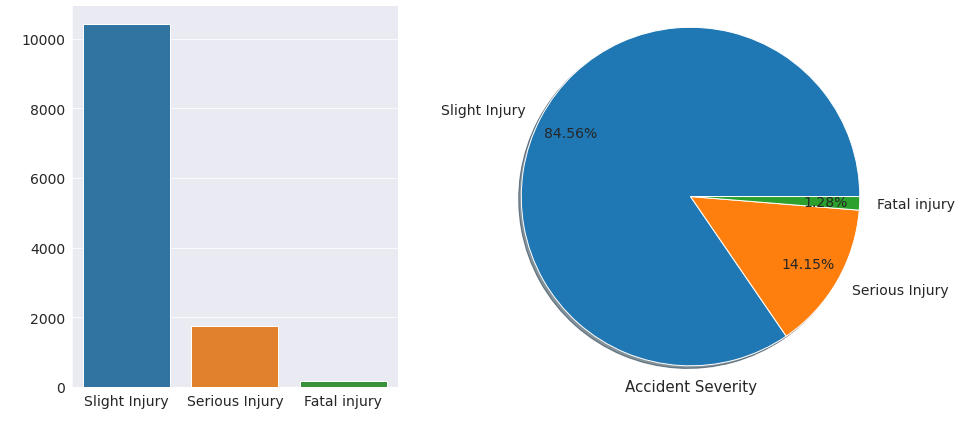

In [14]:
#visualising target variable
plt.figure(figsize=(14,7))
#barplot
ax1 = plt.subplot(1,2,1)
cp = sns.countplot(x =df.accident_severity)
ax1.set_xlabel(" ")
ax1.set_ylabel(" ")
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
sns.despine(top = True,right = True)
#pieplot
ax2 = plt.subplot(1,2,2)
plt.pie(df.accident_severity.value_counts(),
        labels = list(df.accident_severity.unique()),
        autopct = '%1.2f%%',
        pctdistance=0.8,
        shadow = True,
        radius=1.3,
        textprops= {'fontsize':14})
ax2.set_xlabel(" ")
plt.xlabel('Accident Severity',fontsize = 15,labelpad = 20)
plt.subplots_adjust(wspace=0.4)
plt.show()

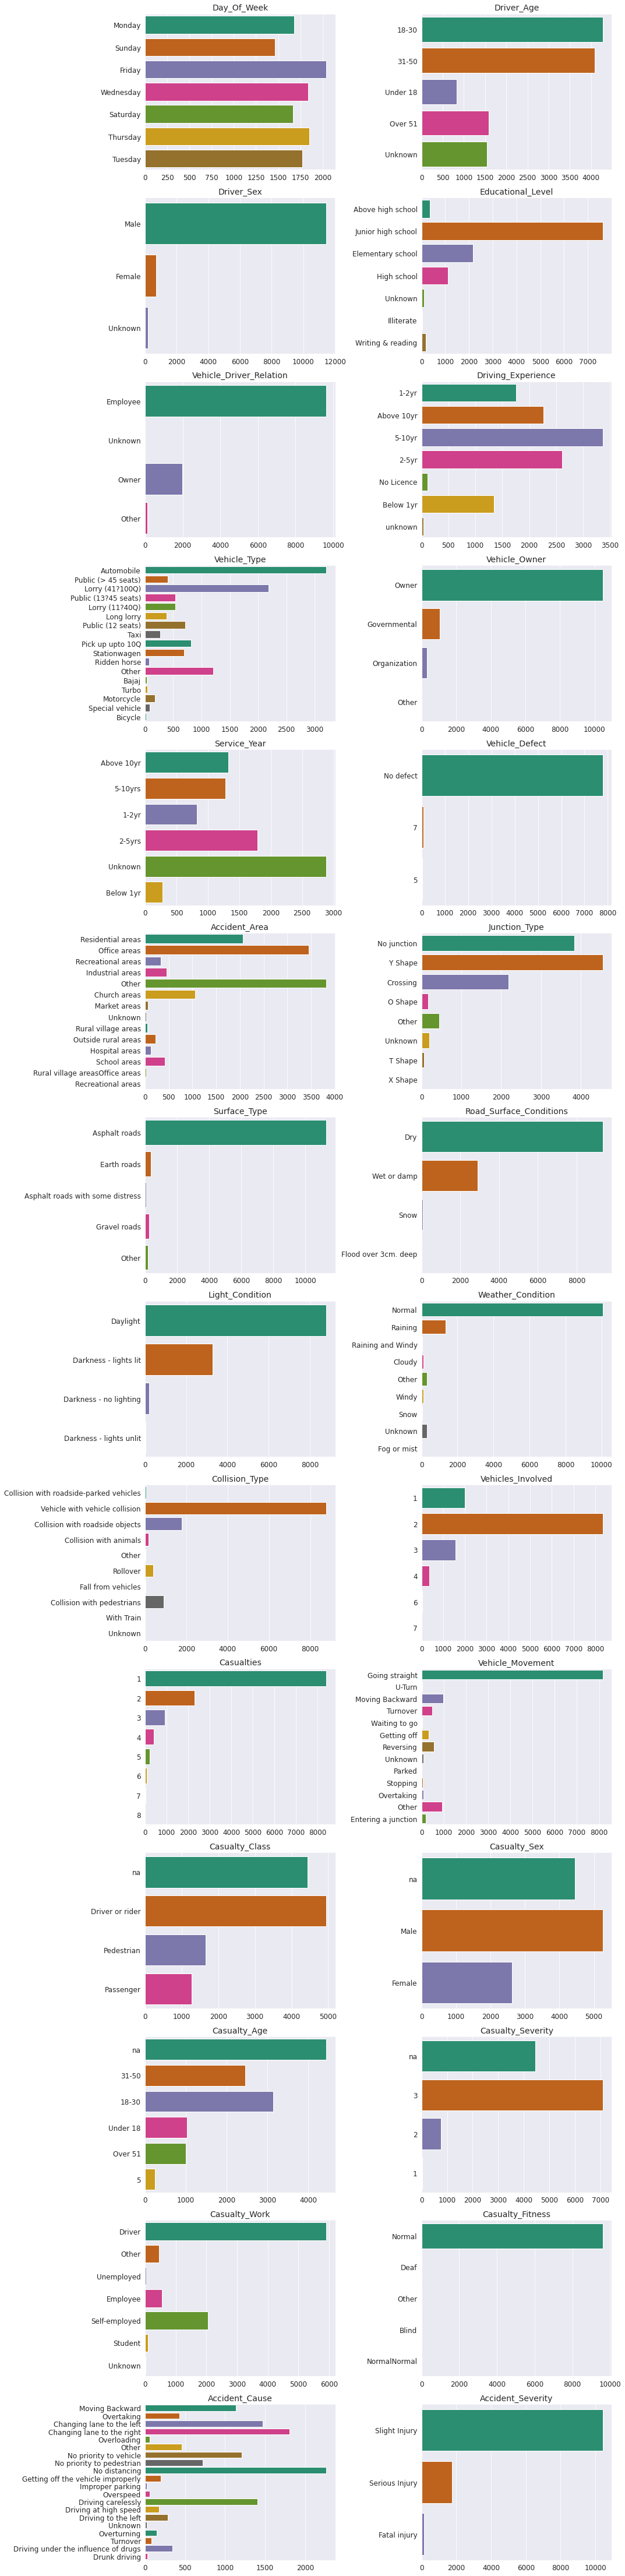

In [15]:
plt.figure(figsize=(15,70))
plotnumber = 1

for col in df.drop(['hour', 'minute', 'lanes', 'road_allignment', 'pedestrian_movement'], axis=1):
    if plotnumber <= df.shape[1]:
        ax1 = plt.subplot(16,2,plotnumber)
        sns.countplot(data=df, y=col, palette='Dark2')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title(col.title(), fontsize=14)
        plt.xlabel('')
        plt.ylabel('')
    plotnumber +=1
plt.tight_layout()

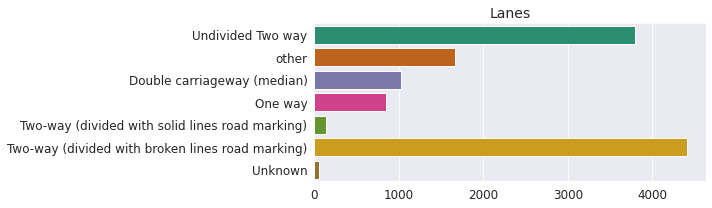

In [16]:
plt.figure(figsize=(10,3))
sns.countplot(data=df, y='lanes', palette = 'Dark2')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Lanes', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

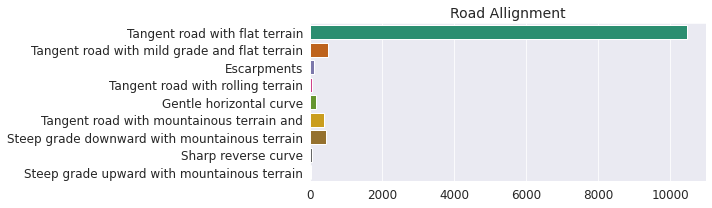

In [17]:
plt.figure(figsize=(10,3))
sns.countplot(data=df, y='road_allignment', palette = 'Dark2')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Road Allignment', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

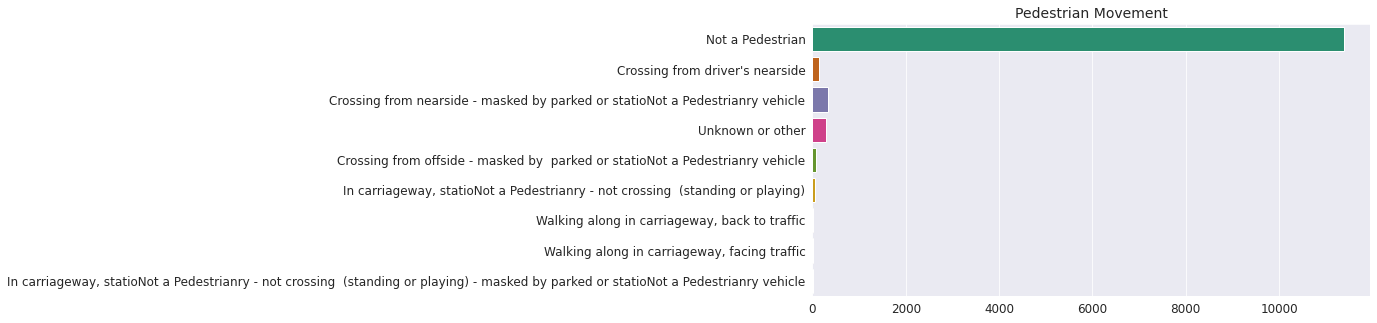

In [18]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, y='pedestrian_movement', palette = 'Dark2')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Pedestrian Movement', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

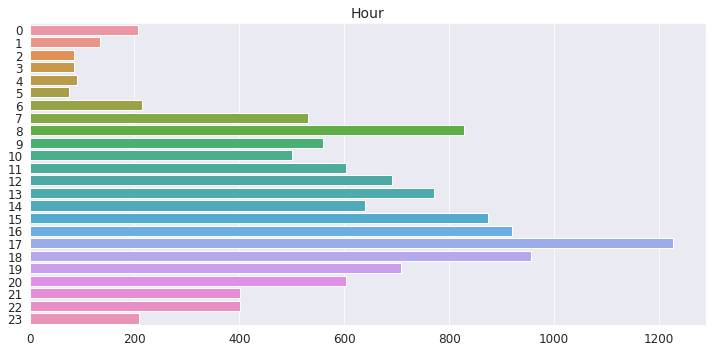

In [19]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, y='hour')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Hour', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

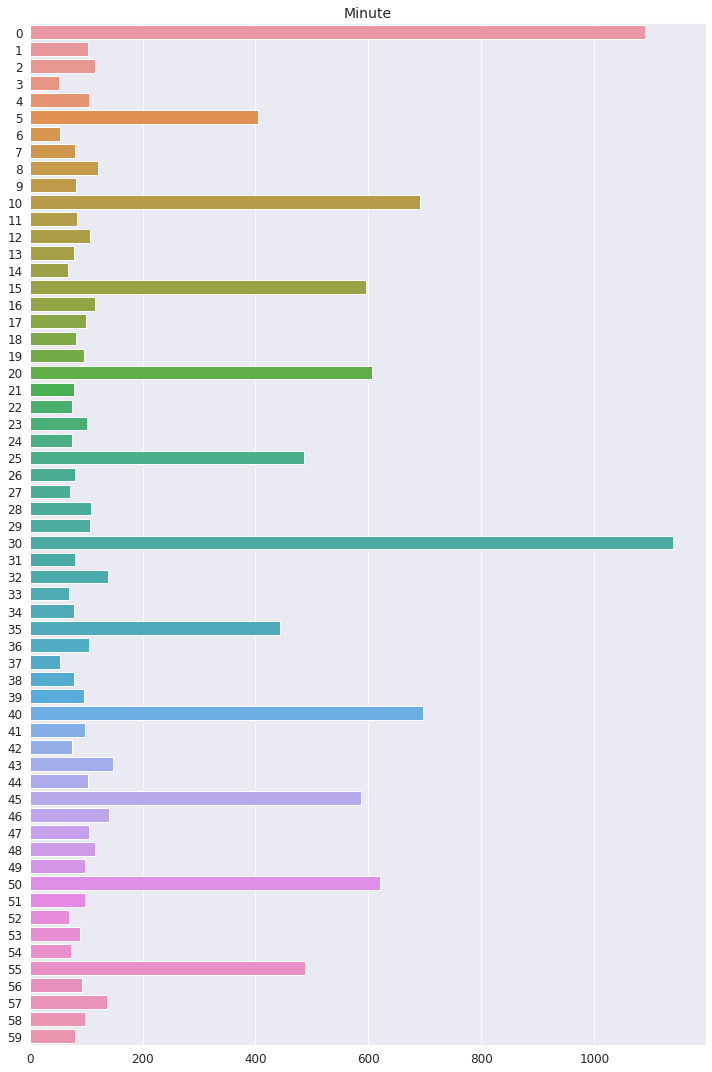

In [20]:
plt.figure(figsize=(10,15))
sns.countplot(data=df, y='minute')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Minute', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

#### Observations:

Most of the accidents:
* involved 2 vehicles and 2 casualties
* occured on Fridays and after noon hours

Most of the drivers:
* are male and in 18-30 yrs age group
* have only went upto Junior high school and are employees
* have 5-10 yrs of driving experience

Most of the accidents happened with personally owned passenger vehicles.

Most of the drivers have met with accident on:
* two-way lanes
* tangent road with flat terrains
* Y shaped junctions
* asphalt roads
* day time
* normal weather conditions

Most of the casualties:
* happened to physically fit male drivers
* are of severity 3

The conditions on which most of the drivers met with the accident are:
* vehicle to vehicle collision
* straight movement
* no pedestrian accidents

Not keeping enough distance between the vehicles was the major cause for most of the accidents and majority of the accidents resulted in slight injury.


#### Observations:
* Most of the accidents have taken place between 3pm to 6pm with maximum numbers at 5 pm
* Most of the time in minutes seems to have been recorded in intervals of 5 minutes for the sake of convenience. Hence more numbers to be seen at the 0 and 30 minutes.

In [21]:
min = list(range(5,56, 5))
def convert_minutes(x: int):
    for m in min:
        if x % m == x and x > m-5:
            return m
        if x in [56,57,58,59]:
            return 0
        if x in min+[0]:
            return x

In [22]:
df['minute'] = df['minute'].apply(lambda x: convert_minutes(x))

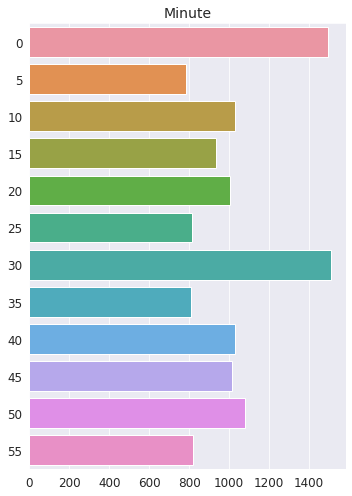

In [23]:
plt.figure(figsize=(5,7))
sns.countplot(data=df, y='minute')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Minute', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

In [24]:
df.isna().sum()[df.isna().sum() != 0]

educational_level           741
vehicle_driver_relation     579
driving_experience          829
vehicle_type                950
vehicle_owner               482
service_year               3928
vehicle_defect             4427
accident_area               239
lanes                       385
road_allignment             142
junction_type               887
surface_type                172
collision_type              155
vehicle_movement            308
casualty_work              3198
casualty_fitness           2635
dtype: int64

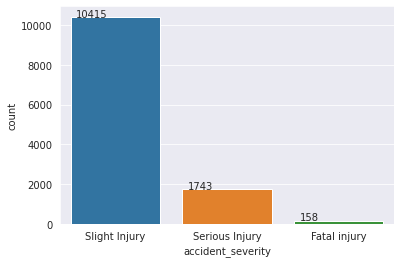

In [25]:
ax = sns.countplot(x=df["accident_severity"])
for p in ax.patches:
      ax.annotate(f'{p.get_height()}', (p.get_x()+0.05, p.get_height()+1))

plt.show()

# Preprocessing

In [26]:
# dropping columns that can cause imbalance while imputation
df.drop(columns = ['vehicle_defect', 'vehicle_driver_relation', 'casualty_work', 'casualty_fitness',], inplace=True)

In [27]:
def getNumericalAndCategorical(df):
    numeric_var_names = [key for key in dict(df.dtypes)
                         if dict(df.dtypes)[key] in ['float64', 'int64', 'float32', 'int32','float16','int16']]
    cat_var_names = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] not in ['float64', 'int64',
                                                                                        'float32', 'int32','float16','int16']]
    return [numeric_var_names, cat_var_names]

categoricals = getNumericalAndCategorical(df)[1]

In [28]:
df[categoricals].isnull().sum()

day_of_week                   0
driver_age                    0
driver_sex                    0
educational_level           741
driving_experience          829
vehicle_type                950
vehicle_owner               482
service_year               3928
accident_area               239
lanes                       385
road_allignment             142
junction_type               887
surface_type                172
road_surface_conditions       0
light_condition               0
weather_condition             0
collision_type              155
vehicle_movement            308
casualty_class                0
casualty_sex                  0
casualty_age                  0
casualty_severity             0
pedestrian_movement           0
accident_cause                0
accident_severity             0
dtype: int64

In [29]:
len(categoricals)

25

In [30]:
X = df.drop('accident_severity', axis=1)
y = df[['accident_severity']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8621, 28) (3695, 28) (8621, 1) (3695, 1)


In [31]:
weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                            classes=np.unique(y['accident_severity']),
                                            y = y['accident_severity'])
class_weights_dicts = dict(zip(list(np.unique(y['accident_severity'])),weights))
class_weights_dicts

{'Fatal injury': 25.9831223628692,
 'Serious Injury': 2.3553260661694395,
 'Slight Injury': 0.39417506801088176}

In [32]:
to_enc = [i for i in categoricals if i!= 'accident_severity']

In [33]:
categorical_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'most_frequent')),
                                            ('ohe',OrdinalEncoder(handle_unknown ='use_encoded_value',
                                                                  unknown_value = -1))])

transformer = ColumnTransformer(transformers = [('categorical_df_preprocessing', categorical_transformer,to_enc)])

#pipeline_xgb = Pipeline([('transformer',transformer),('XGB',
#                                                     XGBClassifier(n_jobs = -1,sample_weight = class_weights_dicts))])

pipeline_rf = Pipeline([('transformer',transformer),('RandomForest',
                                                     RandomForestClassifier(class_weight=class_weights_dicts,
                                                                            n_estimators=100,n_jobs = -1,criterion='entropy'))])
pipeline_ext = Pipeline([('transformer',transformer),('RandomForest',
                                                      ExtraTreesClassifier(class_weight = class_weights_dicts, n_jobs = -1))])
models = [pipeline_rf,pipeline_ext]

In [34]:
def modelling(X_train, y_train, X_test, y_test):
    for i in models:
        i.fit(X_train,y_train)
        y_pred = i.predict(X_test)
        print(i[1][0],[accuracy_score(y_test, y_pred)])

In [35]:
modelling(X_train,y_train, X_test, y_test)

DecisionTreeClassifier(criterion='entropy', max_features='auto',
                       random_state=1791778690) [0.8365358592692829]
ExtraTreeClassifier(random_state=1051486133) [0.8362652232746955]


In [36]:
# rfe = pipeline_rf.fit(X_train, y_train)
# y_pred_rfe = extree.predict(X_test)
extree = pipeline_ext.fit(X_train, y_train)
y_pred_extree = extree.predict(X_test)

In [37]:
def model_performance(model, y_test, y_hat) : 
    conf_matrix = confusion_matrix(y_test, y_hat)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)", "2 (pred)"],
                        y = ["0 (true)","1 (true)", "2 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #Show metrics
    Accuracy  =  accuracy_score(y_test, y_hat)
    Precision =  precision_score(y_test, y_hat, average= 'weighted')
    Recall    =  recall_score(y_test, y_hat, average= 'weighted')
    F1_score  =  f1_score(y_test, y_hat, average= 'weighted')

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
 
     
    #plots
    model = model
    
    #Subplots
    fig = tls.make_subplots(rows=2, cols=1, print_grid=False, 
                          subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        ))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,2,1)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                        autosize = True, height = 800,width = 800,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        # margin = dict(b = 100)
                        )
    fig.layout.titlefont.size = 14
    
    py.iplot(fig)

In [38]:
model_performance(extree,y_test, y_pred_extree)
del X_train,y_train, X_test, y_test
gc.collect()

26787

# Hyperparameter Tuning

In [39]:
#Encoding Because here building model without Pipeline
def ordinal_encoder(df, feats): 
    for feat in feats:    
        feat_val = list(1+np.arange(df[feat].nunique()))
        feat_key = list(df[feat].sort_values().unique())
        feat_dict = dict(zip(feat_key, feat_val))
        df[feat] = df[feat].map(feat_dict)
    return df

df = ordinal_encoder(df, df.drop(['accident_severity'], axis=1).columns)
df.shape

(12316, 29)

In [40]:
#Imputing Columns
impute_cols = [x for x in df.isna().sum()[df.isna().sum() != 0].index.tolist()]
for feat in impute_cols:
    mode = df[feat].mode()[0]
    df[feat].fillna(mode, inplace=True)

In [41]:
X = df.drop('accident_severity', axis=1)
y = df[['accident_severity']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8621, 28) (3695, 28) (8621, 1) (3695, 1)


In [42]:
gkf = KFold(n_splits=3, shuffle=True, random_state=42).split(X=X_train, y=y_train)

# A parameter grid for ETrees
params = {
    'n_estimators': range(100, 500, 100),
    'ccp_alpha': [0.0, 0.1],
    'criterion': ['gini'],
    'max_depth': [5,11],
    'min_samples_split': [2,3],
}

extree_estimator = ExtraTreesClassifier()

gsearch = GridSearchCV(
    estimator= extree_estimator,
    param_grid= params,
    scoring='f1_weighted',
    n_jobs=-1,
    cv=gkf,
    verbose=3,
)

extree_model = gsearch.fit(X=X_train, y=y_train)
(gsearch.best_params_, gsearch.best_score_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


({'ccp_alpha': 0.0,
  'criterion': 'gini',
  'max_depth': 11,
  'min_samples_split': 3,
  'n_estimators': 400},
 0.7810219599578249)

In [43]:
gkf2 = KFold(n_splits=3, shuffle=True, random_state=101).split(X=X_train, y=y_train)

params2 = {
    'n_estimators': range(400, 800, 100),
    'max_depth': [11,15],
    'min_samples_split': [2,3],
    'class_weight': ['balanced', None],

}

extree2 = ExtraTreesClassifier(ccp_alpha = 0.0,
                                criterion = 'gini',
                                max_depth = 11,
                                min_samples_split = 3,
                                n_estimators = 400)

gsearch2 = GridSearchCV(
    estimator= extree2,
    param_grid= params2,
    scoring='f1_weighted',
    n_jobs=-1,
    cv=gkf2,
    verbose=3,
)

extree_model2 = gsearch2.fit(X=X_train, y=y_train)

(gsearch2.best_params_, gsearch2.best_score_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

({'class_weight': 'balanced',
  'max_depth': 11,
  'min_samples_split': 2,
  'n_estimators': 500},
 0.7968631366971887)

In [44]:
extree_tuned = ExtraTreesClassifier(ccp_alpha = 0.0,
                                criterion = 'gini',
                                min_samples_split = 2,
                                class_weight = 'balanced',
                                max_depth = 15,
                                n_estimators = 400)

extree_tuned.fit(X_train, y_train)
y_pred_tuned = extree_tuned.predict(X_test)

In [45]:
print(accuracy_score(y_test,y_pred_tuned))

0.8346414073071718


In [46]:
print(classification_report(y_test,y_pred_extree))

                precision    recall  f1-score   support

  Fatal injury       0.00      0.00      0.00        52
Serious Injury       0.00      0.00      0.00       552
 Slight Injury       0.84      1.00      0.91      3091

      accuracy                           0.84      3695
     macro avg       0.28      0.33      0.30      3695
  weighted avg       0.70      0.84      0.76      3695



In [47]:
shap.initjs()

In [48]:
X_sample = X_train.sample(100)

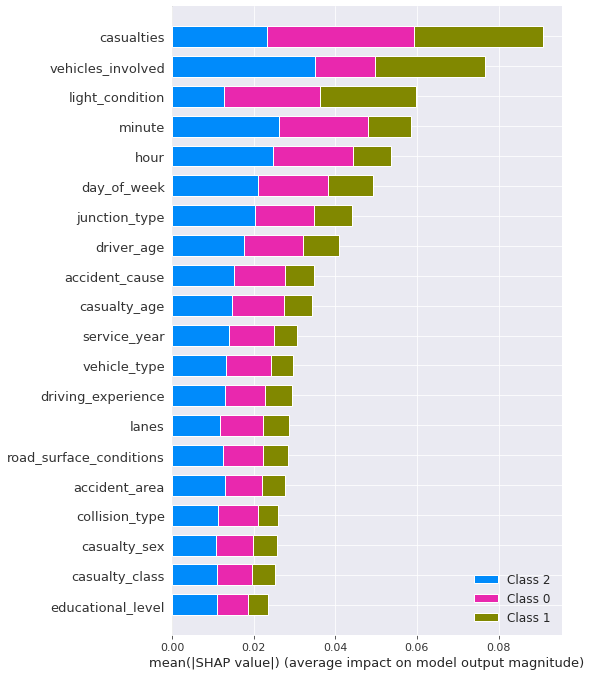

In [49]:
shap_values = shap.TreeExplainer(extree_tuned).shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, plot_type="bar")

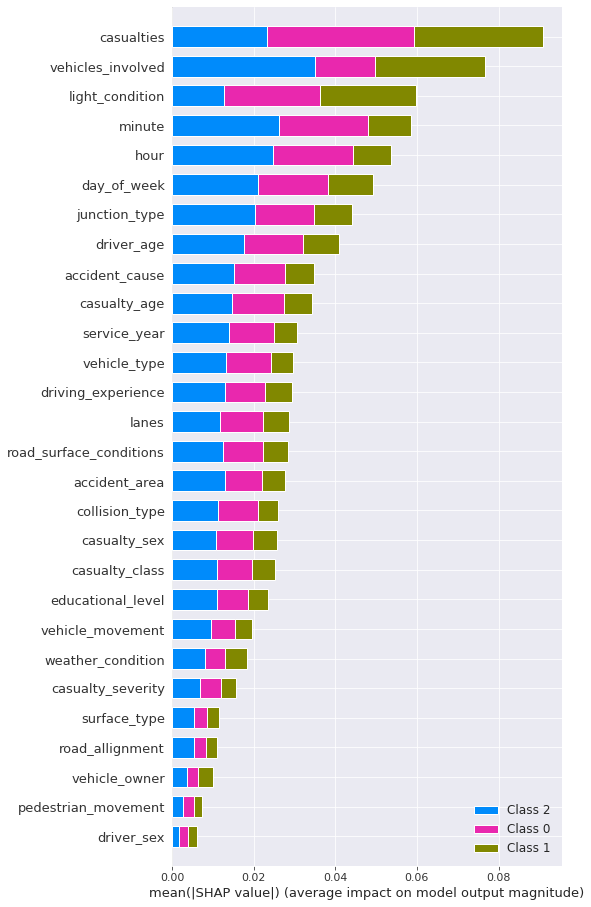

In [50]:
shap.summary_plot(shap_values, X_sample, max_display=28)

In [51]:
shap.force_plot(shap.TreeExplainer(extree_tuned).expected_value[0],
                shap_values[0][:], 
                X_sample)

In [52]:
print(y_pred_tuned[50])
shap.force_plot(shap.TreeExplainer(extree_tuned).expected_value[0], shap_values[1][50], X_sample.iloc[50])

Slight Injury


In [53]:
i=13
print(y_pred_tuned[i])
shap.force_plot(shap.TreeExplainer(extree_tuned).expected_value[0], shap_values[0][i], X_sample.values[i], feature_names = X_sample.columns)

Slight Injury


Slight Injury


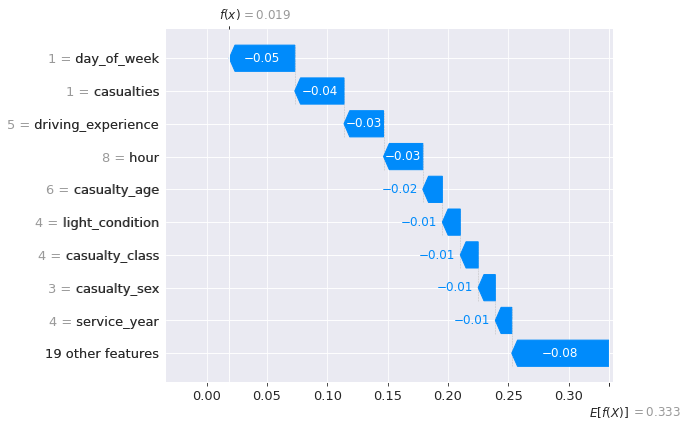

In [54]:
print(y_pred_tuned[10])
row = 10
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                              base_values=shap.TreeExplainer(extree_tuned).expected_value[0], data=X_sample.iloc[row],  
                                         feature_names=X_sample.columns.tolist()))

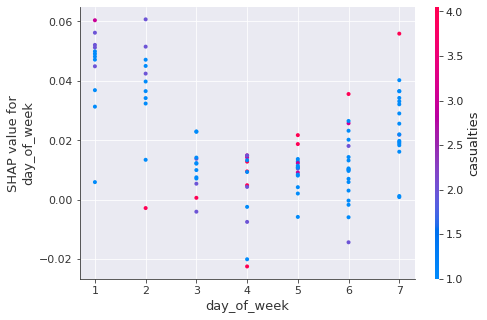

In [55]:
shap.dependence_plot('day_of_week', shap_values[2], X_sample)

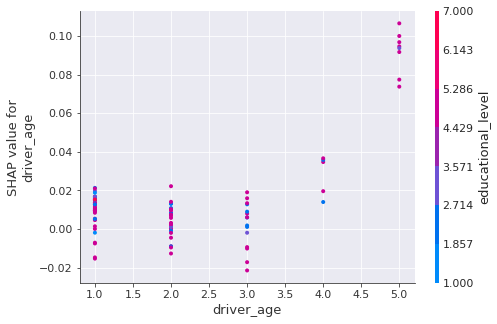

In [56]:
shap.dependence_plot('driver_age', shap_values[2], X_sample)

Slight Injury


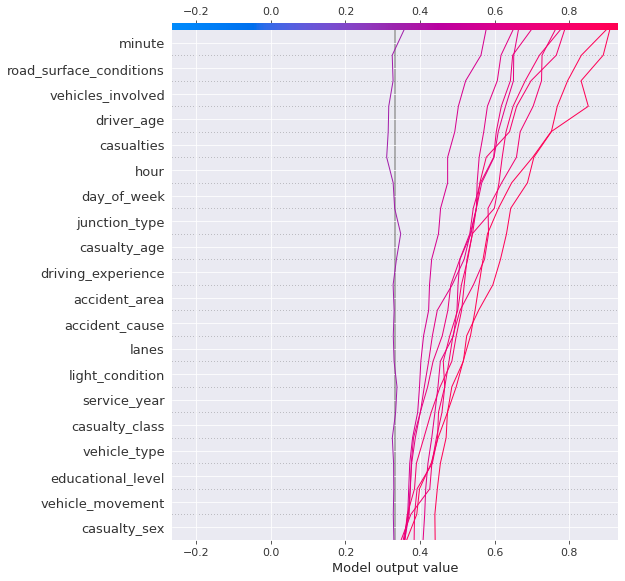

In [57]:
print(y_pred_tuned[10])
shap.decision_plot(shap.TreeExplainer(extree_tuned).expected_value[0], 
                   shap_values[2][:10], 
                   feature_names=X_sample.columns.tolist())